<a href="https://colab.research.google.com/github/aparnasree2020/sampledata_casws/blob/main/Run_XGboost_Models_compare_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install packages

In [5]:
# Comment after installation so that the whole notebook can be run in one go
#install.packages('xgboost')
install.packages('pROC')
install.packages('reshape2')




Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘plyr’, ‘Rcpp’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



# Load Libraries

In [6]:
library(dplyr)
library(tidyverse)
library(xgboost)
library('pROC')
library(reshape2 )

#library(measures)

Type 'citation("pROC")' for a citation.


Attaching package: ‘pROC’


The following objects are masked from ‘package:stats’:

    cov, smooth, var



Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths




# Load CSV datafile - Split data into train and test at 80/20 split

*   List item
*   List item

In [4]:
train_file <- "https://raw.github.com/aparnasree2020/sampledata_casws/master/Unbalanced_train_clean.csv"
test_file <- "https://raw.github.com/aparnasree2020/sampledata_casws/master/Unbalanced_test_clean.csv"
train_data <- read.csv(file =train_file, header = TRUE )
test_data <- read.csv(file =test_file, header = TRUE )
x_train <- train_data[, !names(train_data) %in% "claim_count_pd"]
y_train <- train_data$claim_count_pd
x_test <- test_data[, !names(test_data) %in% "claim_count_pd"]
y_test <- test_data$claim_count_pd

#XGboost with standard hyperparameters ( no tuning) 

In [ ]:
fit <- xgboost(data = as.matrix(x_train), label = y_train, nrounds = 100, objective = "binary:logistic", eta = 0.3, max_depth = 6,silent = 1)
pred_y_test <- predict(fit, as.matrix(x_test)) # Predict the classes for the test data
pred_y_test_bin = ifelse(pred_y_test > 0.5, 1, 0)
dataout_XGboost_simple <- data.frame(pred_y_test_bin, y_test)

#XGboost with advanced hyper parameters
The hyperparameters used are:

*   eta (learning rate): Controls the step-size at which the optimizer makes updates to the weights.
*   max_depth: The maximum depth of a tree.
* min_child_weight: The minimum weight required for a child to be split.
* subsample: The fraction of the training data used in each iteration.
* colsample_bytree: The fraction of the columns used in each iteration.
* gamma: The minimum loss reduction required to make a split.
* alpha: L1 regularization parameter.
* lambda: L2 regularization parameter.
* nthread: The number of parallel threads used to run XGBoost.
* seed: The random seed used to initialize the weights.

These hyperparameters can be fine-tuned to achieve the best performance for a particular problem. The values given here are just an example and may need to be adjusted for different datasets.

In [ ]:
# Train the model
fit_advanced <- xgboost(data = as.matrix(x_train), label = y_train, nrounds = 100, objective = "binary:logistic",
               eta = 0.3,
               max_depth = 6,
               min_child_weight = 1,
               subsample = 0.8,
               colsample_bytree = 0.8,
               gamma = 0,
               alpha = 0,
               lambda = 1,
               nthread = 4,
               seed = 123)

#XGboost with  hyperparameter tuning

In [ ]:
# Split data into training and testing sets
set.seed(123)
idx <- sample(nrow(train), round(0.7 * nrow(train)))
x_train <- train[idx, ]
y_train <- label[idx]
x_test <- train[-idx, ]
y_test <- label[-idx]

# Define parameter grid
param_grid <- list(
  eta = c(0.01, 0.1, 1),
  max_depth = c(3, 6, 9),
  min_child_weight = c(1, 5, 10)
)

# Train and tune the model using cross-validation
tune <- xgb.cv(
  data = as.matrix(x_train),
  label = y_train,
  nfold = 5,
  objective = "multi:softmax",
  num_class = length(unique(y_train)),
  params = list(
    nrounds = 100,
    verbose = 0,
    early_stopping_rounds = 10
  ),
  grid = param_grid
)

# Identify best hyperparameters
best_eta <- tune$best_params$eta
best_max_depth <- tune$best_params$max_depth
best_min_child_weight <- tune$best_params$min_child_weight

# Train the model using the best hyperparameters
model <- xgboost(
  data = as.matrix(x_train),
  label = y_train,
  nrounds = 100,
  objective = "multi:softmax",
  num_class = length(unique(y_train)),
  params = list(
    eta = best_eta,
    max_depth = best_max_depth,
    min_child_weight = best_min_child_weight,
    verbose = 0
  )
)

# Make predictions on the test set
pred <- predict(model, as.matrix(x_test))

#Calcualte the metric for each model

In [ ]:
library(pROC)

# Define a function to compute the metrics for one model
compute_model_metrics <- function(pred, true, var_name) {
  tn <- sum((pred == 0) & (true == 0))
  fp <- sum((pred == 1) & (true == 0))
  fn <- sum((pred == 0) & (true == 1))
  tp <- sum((pred == 1) & (true == 1))
  total <- length(pred)
  
  accuracy <- (tp + tn) / total
  precision <- tp / (tp + fp)
  sensitivity <- tp / (tp + fn)
  f1_score <- 2 * precision * sensitivity / (precision + sensitivity)
  
  roc <- roc(true, pred)
  auc <- auc(roc)
  gini <- (auc * 2) - 1
  
  # Create a data frame to store the metrics
  metrics_df <- data.frame(var_name = var_name,
                           accuracy = accuracy,
                           precision = precision,
                           sensitivity = sensitivity,
                           f1_score = f1_score,
                           roc_auc = auc,
                           gini = gini,
                           TP = tp,
                           FP = fp,
                           TN = tn,
                           FN = fn,
                           Samples = total)
  
  # Return the data frame
  return(metrics_df)
}
# Compute the metrics for each model and combine the resulting data frames
metrics_df <- rbind(compute_model_metrics(dataout_XGboost_simple$pred_y_test_bin, dataout_XGboost_simple$y_test, "XGBoost"),
                    compute_model_metrics(dataout_GBM$pred_y_test_bin, dataout_XGboost_simple$y_test, "GBM"),
                    compute_model_metrics(dataout_GLM$pred_y_test_bin, dataout_GLM$y_test, "GLM"))
#print(metrics_df)

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



# Pretty print table of metrics

In [ ]:
knitr::kable(metrics_df,digits = 2)



|var_name | accuracy| precision| sensitivity| f1_score|   roc_auc| gini|  TP| FP|    TN|   FN| Samples|
|:--------|--------:|---------:|-----------:|--------:|---------:|----:|---:|--:|-----:|----:|-------:|
|XGBoost  |     0.91|      0.98|        0.07|     0.13| 0.5360971| 0.07| 580|  9| 71971| 7440|   80000|
|GBM      |     0.90|       NaN|        0.00|      NaN| 0.5000000| 0.00|   0|  0| 71980| 8020|   80000|
|GLM      |     0.90|      0.50|        0.00|     0.00| 0.5001108| 0.00|   2|  2| 71978| 8018|   80000|

In [ ]:
library(flextable)

#Plot the various metrics as plots

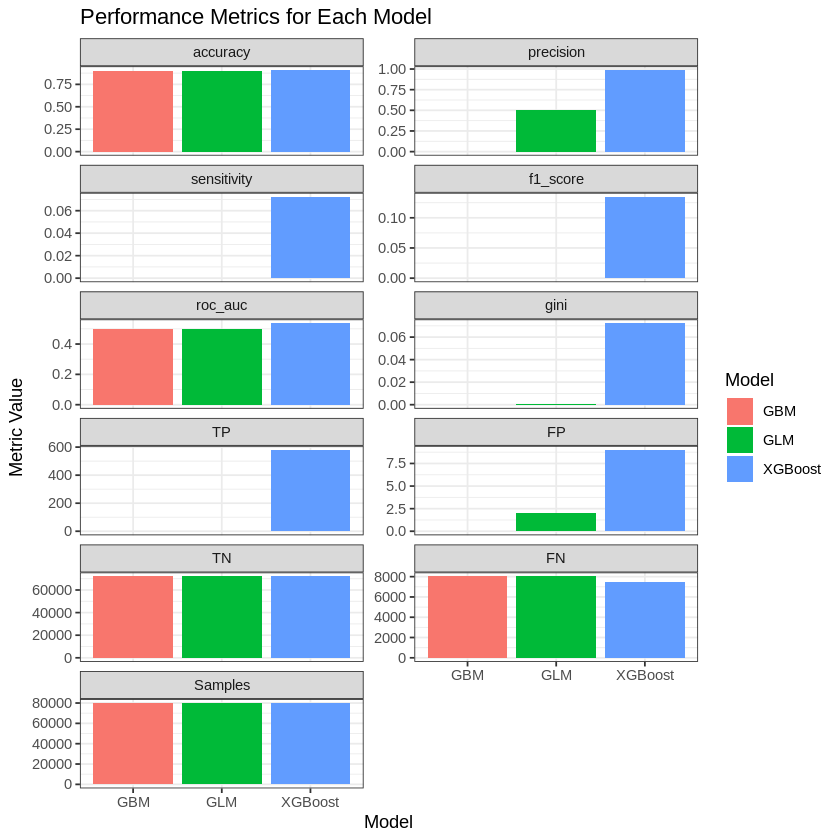

In [ ]:
options(warn=-1)
# Melt the data frame to a long format for plotting
metrics_df_melt <- melt(metrics_df, id.vars = "var_name", variable.name = "metric")

# Plot each performance metric for each model using ggplot2 and facet_wrap()
ggplot(metrics_df_melt, aes(x = var_name, y = value, fill = var_name)) +
  geom_bar(stat = "identity", position = "dodge") +
  labs(x = "Model", y = "Metric Value", fill = "Model") +
  ggtitle("Performance Metrics for Each Model") +
  facet_wrap(~metric, scales = "free_y", nrow = 10) +
  theme_bw() +
  theme(plot.background = element_rect(fill = "white", size = 4),
        panel.background = element_rect(fill = "white", size = 4))

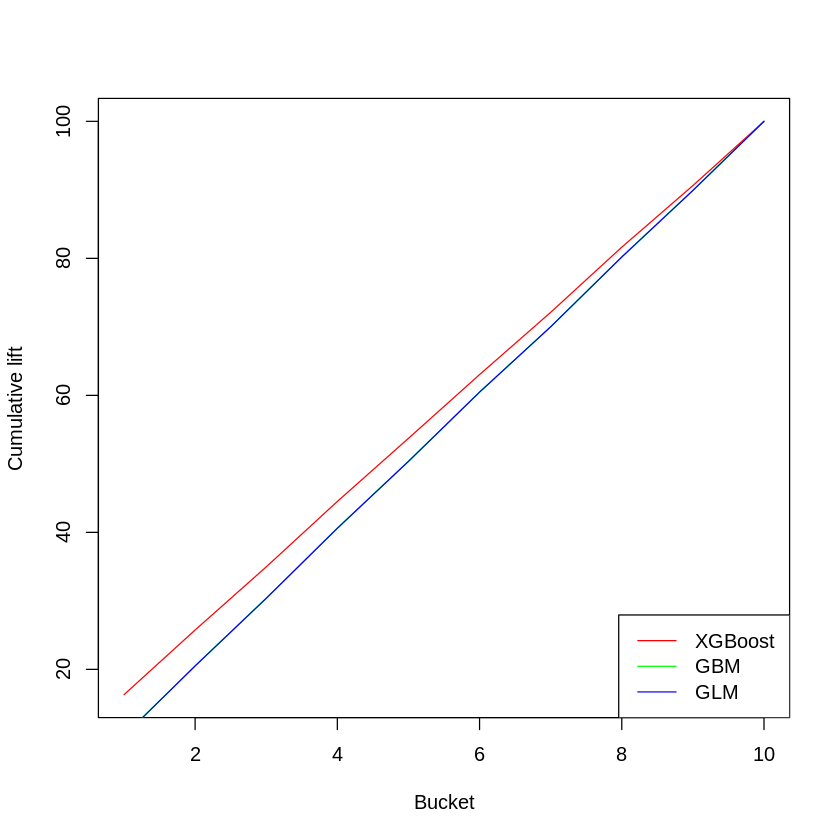

In [ ]:
library(dplyr)
options(warn=-1)
# Define the lift function
lift <- function(depvar, predcol, groups=10) {
  if(!require(dplyr)) {
    install.packages("dplyr")
    library(dplyr)
  }
  if(is.factor(depvar)) depvar <- as.integer(as.character(depvar))
  if(is.factor(predcol)) predcol <- as.integer(as.character(predcol))
  helper = data.frame(cbind(depvar, predcol))
  helper[,"bucket"] = ntile(-helper[,"predcol"], groups)
  gaintable = helper %>% group_by(bucket)  %>%
    summarise_at(vars(depvar), funs(total = n(),
                                    totalresp=sum(., na.rm = TRUE))) %>%
    mutate(Cumresp = cumsum(totalresp),
           Gain=Cumresp/sum(totalresp)*100,
           Cumlift=Gain/(bucket*(100/groups)))
  return(gaintable)
}

# Example usage
dt1 <- lift(dataout_XGboost_simple$y_test, dataout_XGboost_simple$pred_y_test_bin, groups = 10)
dt2 <- lift(dataout_GBM$y_test, dataout_GBM$pred_y_test_bin, groups = 10)
dt3 <- lift(dataout_GLM$y_test, dataout_GLM$pred_y_test_bin, groups = 10)

# Plot the lift charts with different colors
graphics::plot(dt1$bucket, dt1$Gain, type="l", ylab="Cumulative lift", xlab="Bucket", col="red",linetype = "dashed")
lines(dt2$bucket, dt2$Gain, col="green")
lines(dt3$bucket, dt3$Gain, col="blue",linetype = "dashed")
legend("bottomright", legend=c("XGBoost", "GBM", "GLM"), col=c("red", "green", "blue"), lty=1)

# End

Unused code below

In [ ]:
#library(Hmisc)
#hist.data.frame(gbm_data$claim_count_pd)